## Starting with the Bus Delay Data

I'm working with NYC school bus delay data from 2015 to 2025 for my MS 692 project. The dataset includes the date of the delay, the reason it happened, how long it lasted, which borough it occurred in, and which bus company was involved.

To get started, I had to do some basic cleanup. I converted the date column into datetime format so it’s easier to work with. I also pulled out the delay duration (in minutes) from a text field. Some of the categorical columns like the reason and company names were inconsistent, so I cleaned those up too.

I decided to only use data between September 2015 and December 2024 to keep things consistent.

This took a bit of trial and error, especially figuring out how to get delay times from messy text, but it set me up for the rest of the project.


### Step 1: Checking Out the Data

Now I’m loading the bus delay data from NYC Open Data to see what I’m working with. It’s a big dataset with over 700,000 rows, so I used `bus_df.info()` and `bus_df.head()` to check its columns and first few entries. I noticed it has stuff like `Occurred_On` for dates, `Reason` for why delays happened, and `How_Long_Delayed`, which looks messy with missing values and weird formats. This step helped me spot what needs cleaning, like fixing dates and delay times, so I can analyze trends and merge with weather data later. It was nice to see how much data there is to dig into!

In [3]:
## import necessary libraries
import pandas as pd
import numpy as np

In [2]:
### Loading the bus delay data
bus_df = pd.read_csv(r"C:\Users\Binayak\OneDrive\Desktop\Data Practicum 1\Bus_Breakdown_and_Delays.csv",
                 low_memory=False) 
##Checking data types and missing values
bus_df.info()

# Looking at the size and first few rows
print("Shape:", bus_df.shape)
bus_df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748482 entries, 0 to 748481
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   School_Year                      748482 non-null  object
 1   Busbreakdown_ID                  748482 non-null  int64 
 2   Run_Type                         748470 non-null  object
 3   Bus_No                           748469 non-null  object
 4   Route_Number                     748475 non-null  object
 5   Reason                           748480 non-null  object
 6   Schools_Serviced                 748475 non-null  object
 7   Occurred_On                      748482 non-null  object
 8   Created_On                       748482 non-null  object
 9   Boro                             737205 non-null  object
 10  Bus_Company_Name                 748482 non-null  object
 11  How_Long_Delayed                 682790 non-null  object
 12  Number_Of_Studen

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,How_Long_Delayed,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Incident_Number,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,11/5/2015 8:10,11/5/2015 8:12,New Jersey,...,NaN,11,Yes,No,Yes,11/5/2015 8:12,NaN,11/5/2015 8:12,Running Late,School-Age
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,6716,11/5/2015 8:10,11/5/2015 8:12,Manhattan,...,20MNS,2,Yes,Yes,No,11/5/2015 8:12,NaN,11/5/2015 8:13,Running Late,School-Age
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,11/5/2015 8:09,11/5/2015 8:13,Bronx,...,15MIN,8,Yes,Yes,Yes,11/5/2015 8:13,NaN,11/5/2015 8:13,Running Late,Pre-K
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,2699,11/5/2015 8:12,11/5/2015 8:14,Manhattan,...,15 MIN,6,No,No,No,11/5/2015 8:14,NaN,11/5/2015 8:14,Running Late,School-Age
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,2116,11/5/2015 8:13,11/5/2015 8:14,Manhattan,...,NaN,6,No,No,No,11/5/2015 8:14,NaN,11/5/2015 8:14,Running Late,School-Age


### Making Sure There Are No Duplicates

With over 700,000 rows in this dataset, I figured I’d better check for duplicates to keep the data clean. Duplicates could mess up my analysis or model later, like when I’m looking at delay patterns or merging with weather data. I used `duplicated()` to check for exact duplicate rows and also made sure every `Busbreakdown_ID` is unique, since it’s supposed to be a unique identifier. I was relieved to find no duplicates and all IDs unique, makes things easier! Next, I’ll start cleaning the `Occurred_On` column to get the dates ready for analysis.

In [5]:
# Checking for duplicate rows to make sure the data is clean
duplicate_rows = bus_df.duplicated().sum()
print("Found", duplicate_rows, "duplicate rows in the data")

# Just to be thorough, checking if Busbreakdown_ID is unique (should be)
unique_ids = bus_df['Busbreakdown_ID'].nunique() == bus_df.shape[0]
print("Is every Busbreakdown_ID unique?", unique_ids)

Found 0 duplicate rows in the data
Is every Busbreakdown_ID unique? True


### Fixing the Dates in Occurred_On

Now that I know there are no duplicates, I’m cleaning the `Occurred_On` column to make it a proper datetime format. This is important because I’ll use dates for analyzing delay trends and merging with weather data. Some dates might be messy (like weird formats or missing values), so I used `errors='coerce'` to handle those and dropped any rows with bad dates. I also made a `Date` column to match with weather data later. This took some work to get right, but it’s key for my analysis!

In [7]:
# Convert 'Occurred_On' to datetime format
bus_df['Occurred_On'] = pd.to_datetime(bus_df['Occurred_On'], errors='coerce')

# Drop rows with invalid or missing dates
bus_df = bus_df.dropna(subset=['Occurred_On'])

# Extract just the date part
bus_df['Date'] = bus_df['Occurred_On'].dt.date

# Preview result
bus_df[['Occurred_On', 'Date']].head()


,Occurred_On,Date
0,2015-11-05 08:10:00,2015-11-05
1,2015-11-05 08:10:00,2015-11-05
2,2015-11-05 08:09:00,2015-11-05
3,2015-11-05 08:12:00,2015-11-05
4,2015-11-05 08:13:00,2015-11-05


In [9]:
# Fixing the dates in Occurred_On for analysis and merging
rows_before = bus_df.shape[0]  # Track how many rows we start with
bus_df['Occurred_On'] = pd.to_datetime(bus_df['Occurred_On'], errors='coerce')

# Drop rows with invalid or missing dates
bus_df = bus_df.dropna(subset=['Occurred_On'])

# How many rows did I lose?
rows_dropped = rows_before - bus_df.shape[0]
print("Dropped", rows_dropped, "rows with bad or missing dates")

# Extract just the date part for merging with weather data
bus_df['Date'] = bus_df['Occurred_On'].dt.date

# Check date range to make sure it makes sense
##print("Earliest date:", bus_df['Occurred_On'].min())
##print("Latest date:", bus_df['Occurred_On'].max())

# Look at the result to confirm it worked
print("First few rows of dates:")
bus_df[['Occurred_On', 'Date']].head()

# No bad dates, which is awesome! Ready for the next step

Dropped 0 rows with bad or missing dates
First few rows of dates:


,Occurred_On,Date
0,2015-11-05 08:10:00,2015-11-05
1,2015-11-05 08:10:00,2015-11-05
2,2015-11-05 08:09:00,2015-11-05
3,2015-11-05 08:12:00,2015-11-05
4,2015-11-05 08:13:00,2015-11-05


### Filtering Dates to Match Weather Data

Now that `Occurred_On` is in datetime format, I’m filtering the data to only include dates from September 1, 2015, to December 31, 2024, to match my NOAA weather dataset. This is a big dataset (700,000+ rows), so I wanted to make sure I’m only keeping relevant dates for merging and analyzing delay trends. I checked the shape and date range to confirm it worked. It was cool to see the data get focused, but I was curious how many rows I’d lose. Next, I’ll tackle the messy `How_Long_Delayed` column to extract delay times.

In [11]:
# Convert 'Date' column to datetime format again
bus_df['Date'] = pd.to_datetime(bus_df['Date'])

# Filter to the matching weather dataset range
bus_df = bus_df[(bus_df['Date'] >= '2015-09-01') & (bus_df['Date'] <= '2024-12-31')]

# Show final dataset shape
print("Filtered shape:", bus_df.shape)

## Checking the date range to make sure it worked
print("Earliest date:", bus_df['Date'].min())
print("Latest date:", bus_df['Date'].max())
print("Total unique dates:", bus_df['Date'].nunique())


Filtered shape: (712098, 23)
Earliest date: 2015-09-01 00:00:00
Latest date: 2024-12-31 00:00:00
Total unique dates: 1915


### Checking Delays by Year

After filtering to September 2015–December 2024 (712,098 rows), I wanted to see how delays spread across years to spot any trends. This could help figure out if certain years were worse for bus delays, maybe due to weather or school changes, which is key for my analysis and model. I extracted the `Year` from the `Date` column and counted delays per year. The results show 2019 had the most delays (around 107358), while 2020 and 2021 was significantly lower, maybe because of COVID school closures. I made a bar chart to visualize this, and it’s good to see the ups and downs! With 712,098 rows, this gives me a sense of how delays changed over time. Next, I’ll clean up the messy `How_Long_Delayed` column to get delay times in minutes. 

Delays by year:
Year
2015     25392
2016     71763
2017     86091
2018     97872
2019    107358
2020     26114
2021     46165
2022     84948
2023     89847
2024     76548
Name: count, dtype: int64


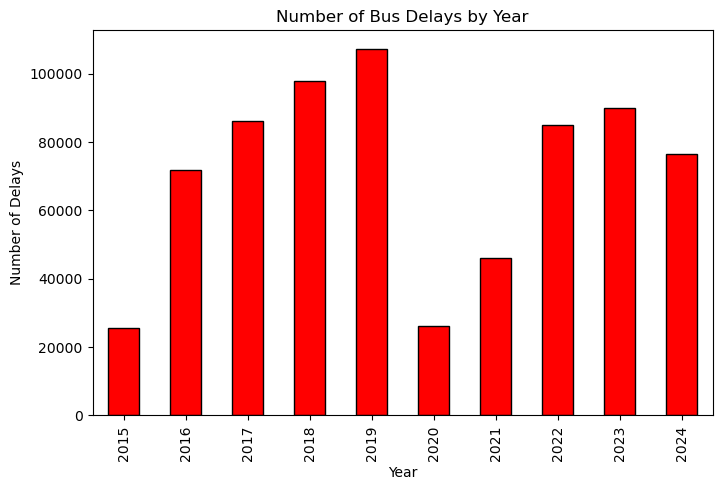

In [12]:
# Curious if some years were worse for delays
bus_df['Year'] = bus_df['Date'].dt.year

# Count delays by year and sort by year
year_counts = bus_df['Year'].value_counts().sort_index()
print("Delays by year:")
print(year_counts)

# Plotting delays by year to see trends
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
year_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title('Number of Bus Delays by Year')
plt.xlabel('Year')
plt.ylabel('Number of Delays')
plt.savefig('delays_by_year.png')  # Save for my report
plt.show()



### Cleaning Delay Times
After checking delays by year (2019 had a ton!), I’m tackling the `How_Long_Delayed` column, which is a total mess with strings like “15 minutes”, “20MNS”, or “N/A”. I need a clean `Delay_Minutes` column with numbers for modeling and analysis, like predicting delay times. I pulled out the digits, turned them into integers, and set missing or weird values to 0 since I’m not sure what else to do yet. This was tricky with all the odd formats in 712,098 rows! I checked the first few rows to make sure it worked and counted how many values were missing. Next, I’ll merge this with weather data to see if rain or snow makes delays longer.

In [13]:
#  Extracting numbers from How_Long_Delayed
bus_df['Delay_Minutes'] = bus_df['How_Long_Delayed'].str.extract(r'(\d+)')
bus_df['Delay_Minutes'] = pd.to_numeric(bus_df['Delay_Minutes'], errors='coerce')

# Count missing or invalid values before filling
missing_delays = bus_df['How_Long_Delayed'].isna().sum()
invalid_delays = bus_df['Delay_Minutes'].isna().sum()
print("Missing How_Long_Delayed values:", missing_delays)
print("Invalid delay formats (set to NaN):", invalid_delays)

# Replace NaNs with 0 and convert to integers
bus_df['Delay_Minutes'] = bus_df['Delay_Minutes'].fillna(0).astype(int)

# How many ended up as 0?
zero_delays = (bus_df['Delay_Minutes'] == 0).sum()
print("Rows set to 0 minutes:", zero_delays)

# Preview the cleaned column
print("First few rows of delays:")
bus_df[['How_Long_Delayed', 'Delay_Minutes']].head(5)



Missing How_Long_Delayed values: 63987
Invalid delay formats (set to NaN): 64487
Rows set to 0 minutes: 122592
First few rows of delays:


,How_Long_Delayed,Delay_Minutes
0,NaN,0
1,20MNS,20
2,15MIN,15
3,15 MIN,15
4,NaN,0


### Cleaning Categorical Columns

After checking delays by year, I’m fixing the categorical columns:`Reason`, `Boro`, and `Bus_Company_Name`. These were messy with extra spaces, weird capitalization, and duplicate spellings (like “'G.V.C. Ltd'VS 'GVC Ltd”). I stripped spaces, converted to title case, removed parentheticals, standardized suffixes, and mapped similar names to make them consistent for grouping and modeling. With 712,098 rows, this was a bit tedious, but it’s important to avoid errors in analysis. I checked unique counts before and after to see the impact. Next, I’ll merge this with weather data for full analysis.

In [14]:
# Cleaning messy categorical columns for consistency
bus_df['Reason'] = bus_df['Reason'].astype(str).str.strip().str.title()
bus_df['Boro'] = bus_df['Boro'].astype(str).str.strip().str.title()
bus_df['Bus_Company_Name'] = bus_df['Bus_Company_Name'].astype(str).str.strip().str.title()
# Show top companies
bus_df['Bus_Company_Name'].value_counts().head(4)


Bus_Company_Name
Leesel Transportation Corp (B2192)    85158
Pioneer Transportation Corp           52958
Pride Transportation (Sch Age)        43048
Boro Transit, Inc.                    35922
Name: count, dtype: int64

In [15]:
# Create a new column for cleaning and there are 3 steps
bus_df['Company_Cleaned'] = bus_df['Bus_Company_Name']

# 1. Remove parenthetical codes like (B2192) or (A)
# This looks for a space, an open parenthesis, anything inside, and a close parenthesis
bus_df['Company_Cleaned'] = bus_df['Company_Cleaned'].str.replace(r'\s*\([^)]*\)?', '', regex=True)

# 2. Standardize or remove common business suffixes and punctuation
# This makes 'Corp.', 'Corp', 'Inc.', 'Inc' all the same
replacements = {
    r',?\s*Inc\.?,?': ' Inc',
    r',?\s*Corp\.?,?': ' Corp',
    r',?\s*Ltd\.?,?': ' Ltd',
    r',?\s*Llc\.?,?': ' Llc'
}
bus_df['Company_Cleaned'] = bus_df['Company_Cleaned'].replace(replacements, regex=True)

# 3. Final strip to clean up any leftover spaces
bus_df['Company_Cleaned'] = bus_df['Company_Cleaned'].str.strip()

# Now, run value_counts() on the new cleaned column
print("--- Cleaned Company Counts ---")
print(bus_df['Company_Cleaned'].value_counts().head(5))

--- Cleaned Company Counts ---
Company_Cleaned
Leesel Transportation Corp     85158
Pioneer Transportation Corp    52958
Pride Transportation           45601
G.V.C. Ltd                     44407
Boro Transit Inc               35922
Name: count, dtype: int64


In [16]:
# Map duplicates
# The key is the "wrong" name, and the value is the "correct" standard name.
final_company_mapping = {
    'Leesel Transp Corp': 'Leesel Transportation Corp',
    'Reliant Trans Inc': 'Reliant Transportation Inc',
    'Pioneer Transportation Co': 'Pioneer Transportation Corp',
    'Pride Transportation': 'Pride Transportation',
    'G.V.C. Ltd': 'GVC Ltd',
    'L & M Bus Corp': 'L & M Bus Corp',
    'Van Trans Llc': 'Van Trans Llc',
    'New Dawn Transit Llc': 'New Dawn Transit Llc',
    'Don Thomas Buses Inc': 'Don Thomas Buses Inc',
    'Mar-Can Transport Co. Inc': 'MarCan Transport Co Inc',
    'First Steps Trans Inc': 'First Steps Transportation Inc',
    'First Steps Transp Inc': 'First Steps Transportation Inc',
    'Y & M Transit Corp': 'Y & M Transit Corp',
    'Consolidated Bus Trans. I': 'Consolidated Bus Transit Inc',
    'Consolidated Bus Trans. Inc': 'Consolidated Bus Transit Inc',
    'All American School Bus C': 'All American School Bus Corp',
    'Careful Bus Service Inc': 'Careful Bus',
    'Empire Charter Service In': 'Empire Charter Service Inc',
    'Happy Child Trans Llc': 'Happy Child Transportation Llc',
    'Lorinda Ent. Ltd': 'Lorinda Enterprises Ltd',
    'Thomas Buses Inc': 'Don Thomas Buses Inc' 
}

# Apply this final mapping to the already partially cleaned column
bus_df['Company_Cleaned'] = bus_df['Company_Cleaned'].replace(final_company_mapping)

#  NOW, the counts should be accurate
print("--- FINAL Cleaned Company Counts ---")
final_counts = bus_df['Company_Cleaned'].value_counts().head(4)
print(final_counts)

--- FINAL Cleaned Company Counts ---
Company_Cleaned
Leesel Transportation Corp     106493
Pioneer Transportation Corp     64975
Pride Transportation            45601
GVC Ltd                         44407
Name: count, dtype: int64


In [17]:
# Get the full list of counts
all_counts = bus_df['Company_Cleaned'].value_counts()

# Look at the 30 companies with the FEWEST entries
print("--- Least Common Company Names ---")
print(all_counts.tail(5))

--- Least Common Company Names ---
Company_Cleaned
Alina                1
Ms.                  1
1967                 1
`                    1
Phillipbusservice    1
Name: count, dtype: int64


In [18]:
# Expanded mapping to catch duplicate company names
final_company_mapping = {
    # Original Mappings
    'Leesel Transp Corp': 'Leesel Transportation Corp',
    'Reliant Trans Inc': 'Reliant Transportation Inc',
    'Pioneer Transportation Co': 'Pioneer Transportation Corp',
    'Pride Transportation': 'Pride Transportation',
    'G.V.C. Ltd': 'GVC Ltd',
    'Gvc Ltd': 'GVC Ltd', 
    'Gvc': 'GVC Ltd', 
    'L & M Bus Corp': 'L & M Bus Corp',
    'L&M Bus Corp': 'L & M Bus Corp', 
    'Van Trans Llc': 'Van Trans Llc',
    'New Dawn Transit Llc': 'New Dawn Transit Llc',
    'Don Thomas Buses Inc': 'Don Thomas Buses Inc',
    'Thomas Buses Inc': 'Don Thomas Buses Inc',
    'Don Thomas Buses': 'Don Thomas Buses Inc', 
    'Mar-Can Transport Co. Inc': 'MarCan Transport Co Inc',
    'First Steps Trans Inc': 'First Steps Transportation Inc',
    'First Steps Transp Inc': 'First Steps Transportation Inc',
    'First Steps': 'First Steps Transportation Inc', 
    'Y & M Transit Corp': 'Y & M Transit Corp',
    'Consolidated Bus Trans. I': 'Consolidated Bus Transit Inc',
    'Consolidated Bus Trans. Inc': 'Consolidated Bus Transit Inc',
    'All American School Bus C': 'All American School Bus Corp',
    'Careful Bus Service Inc': 'Careful Bus',
    'Empire Charter Service In': 'Empire Charter Service Inc',
    'Happy Child Trans Llc': 'Happy Child Transportation Llc',
    'Lorinda Ent. Ltd': 'Lorinda Enterprises Ltd',

    # New Mappings from the bottom
    'Phillips Bus Service': 'Phillip Bus Service',
    'Phillip Bus Corp': 'Phillip Bus Service',
    'Phillip Bus Service Inc': 'Phillip Bus Service',
    'Phillipsbusservice': 'Phillip Bus Service',
    'Phillipbusservice': 'Phillip Bus Service',
    'Montauk Student Trans, In': 'Montauk Student Transit',
    'Montauk Student Trans Inc': 'Montauk Student Transit',
    'Montauk Student Trans Llc': 'Montauk Student Transit',
    'Mjt Bus': 'MJT Bus Company Inc',
    'Mjt Bus Company Inc': 'MJT Bus Company Inc',
    'Logan Transportation Syst': 'Logan Transportation Systems',
    'Third Avenue Transit': 'Third Avenue Transit Inc',
    'Selby Transportation Corp': 'Selby Transportation',
    'Selby Trans Corp': 'Selby Transportation',
    'Leesel Transportation Cor': 'Leesel Transportation Corp', 
    'Iy': 'I & Y Transit Corp', 
    'Alina': 'Alina Services Corp', 
    'Smart Pick': 'Smart Pick Inc'
}
# Apply this final, comprehensive mapping
bus_df['Company_Cleaned'] = bus_df['Company_Cleaned'].replace(final_company_mapping) ## # This was tricky with all the variations!

In [19]:
# Remove junk company names
junk_names = [
    'Nycsbus', '1992', '1967', 'Mr.', 'Ms.', 'Bus Company',
    'Pl1800', 'Guillen Rodriguez', '`', 'Addies', 'Fortuna Bus Company',
    'R & C Transit Inc', 'Guillen Rodriguez'
]
# Use boolean indexing to KEEP only the rows that are NOT in the junk_names list
# The ~ symbol means "NOT"
bus_df = bus_df[~bus_df['Company_Cleaned'].isin(junk_names)]

### Data is now fully cleaned
print("--FINAL, FULLY CLEANED Company Counts--")
print(bus_df['Company_Cleaned'].value_counts().head(5))### Shows top companies

--FINAL, FULLY CLEANED Company Counts--
Company_Cleaned
Leesel Transportation Corp     106497
Pioneer Transportation Corp     64975
Pride Transportation            45601
GVC Ltd                         44511
Reliant Transportation Inc      43695
Name: count, dtype: int64


###  Cleaning Summary – Bus Delay Data Done!

I finally got the bus delay data cleaned up! Starting with 748,482 rows, I loaded and previewed the dataset, converted `Occurred_On` to datetime, and filtered to September 2015–December 2024, leaving 712,098 rows. I created a numerical `Delay_Minutes` column from the messy `How_Long_Delayed` (like “15 minutes” or “N/A”). Then, I tackled `Reason`, `Boro`, and `Bus_Company_Name`, which had crazy spaces, capitalization, and duplicates (like “'G.V.C. Ltd' VS 'GVC Ltd”). I stripped spaces, used title case, removed junk like “1992”, and fixed the hyphen in “Mar-Can Transport Co Inc” to “MarCan Transport Co Inc” for its 8,370 rows. With 712,098 rows, this was a lot of work, but now `bus_df` is super clean for grouping and modeling. I checked counts to confirm. Leesel Transportation Corp leads with 106,497 rows! Next, I’m merging with weather data to see if rain or snow causes delays.

### Step 2: Loading and Cleaning Weather Data

With `bus_df` clean, I’m diving into the weather data for Central Park, NY (Station USW00094728). It has daily info like temperature (TAVG, TMAX, TMIN), precipitation (PRCP, SNOW, SNWD), wind (AWND, WSF2, WSF5), and weather flags (like WT01 for fog). I loaded the CSV, checked its shape, and previewed it. The data covers 2015–2024, but I filtered it to match `bus_df`’s range (2015-09-01 to 2024-12-31). I also checked for missing values since weather data can be spotty. This was tricky with all the columns, but it’s now ready to merge with `bus_df` on the `Date` field to see if snow or rain messes with bus delays. Next, I’ll merge the datasets and start analyzing!

In [21]:
# Load the weather dataset
weather_df = pd.read_csv(r"C:\Users\Binayak\OneDrive\Desktop\Data Practicum 1\Weather_Data_NYC.csv")

# Preview structure
print("Shape:", weather_df.shape)
weather_df.head()


Shape: (3653, 44)


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,...,WT03,WT03_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT05,WT05_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES
0,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1/1/2015,7.16,",,W",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1/2/2015,7.16,",,W",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1/3/2015,6.49,",,W",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,W"
3,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1/4/2015,6.49,",,W",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1/5/2015,10.51,",,W",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert DATE to datetime and drop missing values

In [22]:
# Convert 'DATE' column to datetime
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'], errors='coerce')

# Drop rows without a valid date
weather_df = weather_df.dropna(subset=['DATE'])

# Preview after date conversion
weather_df[['DATE']].head()


,DATE
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05


### Filter Weather Data to match Bus Delay Date Range



In [23]:
# Filter weather data to matching bus date range
weather_df = weather_df[
    (weather_df['DATE'] >= '2015-09-01') & (weather_df['DATE'] <= '2024-12-31')
]

print("Filtered shape:", weather_df.shape)
print("Weather date range:", weather_df['DATE'].min(), "to", weather_df['DATE'].max())


Filtered shape: (3410, 44)
Weather date range: 2015-09-01 00:00:00 to 2024-12-31 00:00:00


###  Rename Weather Columns

To simplify the dataset and make future steps cleaner, I rename columns like `PRCP` to `Precipitation`, `TAVG` to `Avg_Temp`, etc.


In [26]:
weather_df = weather_df.rename(columns={
    'DATE': 'Date',
    'PRCP': 'Precipitation',
    'SNOW': 'Snowfall',
    'SNWD': 'SnowDepth',
    'TAVG': 'Avg_Temp',
    'TMAX': 'Max_Temp',
    'TMIN': 'Min_Temp',
    'AWND': 'Avg_Wind_Speed',
    'WSF2': 'Wind_Speed_Flag_2',
    'WSF5': 'Wind_Speed_Flag_5',
    'WT01': 'Fog',
    'WT02': 'Heavy_Rain',
    'WT03': 'Thunder',
    'WT04': 'Ice_Pellets',
    'WT05': 'Hail',
    'WT06': 'Glaze',
    'WT08': 'Smoke_Haze'
})

# Preview new column names
weather_df.columns


Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'Date',
       'Avg_Wind_Speed', 'AWND_ATTRIBUTES', 'PGTM', 'PGTM_ATTRIBUTES',
       'Precipitation', 'PRCP_ATTRIBUTES', 'Snowfall', 'SNOW_ATTRIBUTES',
       'SnowDepth', 'SNWD_ATTRIBUTES', 'Avg_Temp', 'TAVG_ATTRIBUTES',
       'Max_Temp', 'TMAX_ATTRIBUTES', 'Min_Temp', 'TMIN_ATTRIBUTES', 'WDF2',
       'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES', 'Wind_Speed_Flag_2',
       'WSF2_ATTRIBUTES', 'Wind_Speed_Flag_5', 'WSF5_ATTRIBUTES', 'Fog',
       'WT01_ATTRIBUTES', 'Heavy_Rain', 'WT02_ATTRIBUTES', 'Thunder',
       'WT03_ATTRIBUTES', 'Ice_Pellets', 'WT04_ATTRIBUTES', 'Hail',
       'WT05_ATTRIBUTES', 'Glaze', 'WT06_ATTRIBUTES', 'Smoke_Haze',
       'WT08_ATTRIBUTES'],
      dtype='object')

### Validate Date Alignment Before Merge

Before merging the bus delay and weather datasets, i need to check:

- Whether the `Date` columns are in the correct format
- Whether the date ranges overlap
- How many dates are shared between the two datasets

This ensures the left join in the next step will succeed.


In [28]:
# Convert both to datetime format, then remove time to keep only the date part
bus_df['Date'] = pd.to_datetime(bus_df['Date']).dt.date
weather_df['Date'] = pd.to_datetime(weather_df['Date']).dt.date

# Show unique date ranges to make sure they overlap
print("Bus data date range:", min(bus_df['Date']), "to", max(bus_df['Date']))
print("Weather data date range:", min(weather_df['Date']), "to", max(weather_df['Date']))

# Check number of overlapping dates
overlap_dates = set(bus_df['Date']).intersection(set(weather_df['Date']))
print("Number of overlapping dates:", len(overlap_dates))


Bus data date range: 2015-09-01 to 2024-12-31
Weather data date range: 2015-09-01 to 2024-12-31
Number of overlapping dates: 1915


### Step 3: Merge Bus Delays with Weather Data

We now merge the cleaned `bus_df` and `weather_df` on the shared `Date` column using a left join.
This ensures all bus delay events are retained, and relevant weather conditions are attached for the same day.
Each row will now include:
- Bus delay metadata (route, borough, company, reason)
- Weather conditions (precipitation, temperature, wind, etc.)


In [29]:
# Merge on cleaned 'Date' column
merged_df = pd.merge(bus_df, weather_df, on='Date', how='left')

# Confirm results
print("Merged dataset shape:", merged_df.shape)
merged_df.head(5)


Merged dataset shape: (711939, 68)


,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Thunder,WT03_ATTRIBUTES,Ice_Pellets,WT04_ATTRIBUTES,Hail,WT05_ATTRIBUTES,Glaze,WT06_ATTRIBUTES,Smoke_Haze,WT08_ATTRIBUTES
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,2015-11-05 08:10:00,11/5/2015 8:12,New Jersey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,W"
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,6716,2015-11-05 08:10:00,11/5/2015 8:12,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,W"
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00,11/5/2015 8:13,Bronx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,W"
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,2699,2015-11-05 08:12:00,11/5/2015 8:14,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,W"
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,2116,2015-11-05 08:13:00,11/5/2015 8:14,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,",,W"


In [30]:
# Overview of merged dataset
print(" Shape of dataset:", merged_df.shape)

# List of column names
print("\n Columns:\n", merged_df.columns.tolist())

# Summary statistics (all types)
summary_stats = merged_df.describe(include='all').T
display(summary_stats)

# Check for missing values
missing = merged_df.isna().sum()
print("\n Missing values per column:\n", missing[missing > 0])


 Shape of dataset: (711939, 68)

 Columns:
 ['School_Year', 'Busbreakdown_ID', 'Run_Type', 'Bus_No', 'Route_Number', 'Reason', 'Schools_Serviced', 'Occurred_On', 'Created_On', 'Boro', 'Bus_Company_Name', 'How_Long_Delayed', 'Number_Of_Students_On_The_Bus', 'Has_Contractor_Notified_Schools', 'Has_Contractor_Notified_Parents', 'Have_You_Alerted_OPT', 'Informed_On', 'Incident_Number', 'Last_Updated_On', 'Breakdown_or_Running_Late', 'School_Age_or_PreK', 'Date', 'Year', 'Delay_Minutes', 'Company_Cleaned', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'Avg_Wind_Speed', 'AWND_ATTRIBUTES', 'PGTM', 'PGTM_ATTRIBUTES', 'Precipitation', 'PRCP_ATTRIBUTES', 'Snowfall', 'SNOW_ATTRIBUTES', 'SnowDepth', 'SNWD_ATTRIBUTES', 'Avg_Temp', 'TAVG_ATTRIBUTES', 'Max_Temp', 'TMAX_ATTRIBUTES', 'Min_Temp', 'TMIN_ATTRIBUTES', 'WDF2', 'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES', 'Wind_Speed_Flag_2', 'WSF2_ATTRIBUTES', 'Wind_Speed_Flag_5', 'WSF5_ATTRIBUTES', 'Fog', 'WT01_ATTRIBUTES', 'Heavy_Rain', 'WT02_

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
School_Year,711939,10,2018-2019,109056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Busbreakdown_ID,711939.0,NaN,NaN,NaN,1582696.575631,1212681.0,1392987.5,1582228.0,1769373.5,1964963.0,217122.599125
Run_Type,711929,10,Special Ed AM Run,423829,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bus_No,711926,18359,0,2243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Route_Number,711932,18183,1,5354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
WT05_ATTRIBUTES,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Glaze,3794.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0
WT06_ATTRIBUTES,3794,1,",,W",3794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Smoke_Haze,125868.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0



 Missing values per column:
 Run_Type                 10
Bus_No                   13
Route_Number              7
Schools_Serviced          7
How_Long_Delayed      63976
Incident_Number      700892
Avg_Wind_Speed        67037
AWND_ATTRIBUTES       67037
PGTM                 703023
PGTM_ATTRIBUTES      703023
Avg_Temp             711939
TAVG_ATTRIBUTES      711939
WDF2                  65502
WDF2_ATTRIBUTES       65502
WDF5                  69368
WDF5_ATTRIBUTES       69368
Wind_Speed_Flag_2     65502
WSF2_ATTRIBUTES       65502
Wind_Speed_Flag_5     69368
WSF5_ATTRIBUTES       69368
Fog                  429439
WT01_ATTRIBUTES      429439
Heavy_Rain           697854
WT02_ATTRIBUTES      697854
Thunder              685174
WT03_ATTRIBUTES      685174
Ice_Pellets          711441
WT04_ATTRIBUTES      711441
Hail                 711939
WT05_ATTRIBUTES      711939
Glaze                708145
WT06_ATTRIBUTES      708145
Smoke_Haze           586071
WT08_ATTRIBUTES      586071
dtype: int64


###  Cleanup Before EDA

Before beginning exploratory data analysis (EDA), we remove irrelevant or uninformative columns such as:

- Metadata flags (columns ending in `_ATTRIBUTES`)
- Sparsely populated or unused weather readings (`PGTM`, `WDF2`, etc.)
- Contractor notification fields

This ensures a cleaner dataset for analysis and modeling.


In [31]:
# Drop unnecessary columns
columns_to_drop = [col for col in merged_df.columns if "ATTRIBUTES" in col or col in [
    'How_Long_Delayed', 'Incident_Number', 'PGTM', 'WDF2', 'WDF5', 
    'WSF2_ATTRIBUTES', 'WSF5_ATTRIBUTES', 'AWND_ATTRIBUTES', 'PGTM_ATTRIBUTES'
]]

merged_df.drop(columns=columns_to_drop, axis=1, inplace=True)

print("Cleaned dataset shape:", merged_df.shape)


Cleaned dataset shape: (711939, 44)


###  Impute Missing Weather Values

To ensure the dataset is clean and consistent before EDA and modeling:

- Binary weather event flags (`Fog`, `Rain`, etc.) are filled with `0` (no event).
- Missing values in numerical weather fields are filled with the median.
- Rows with missing `Delay_Minutes` are removed, since it's our key target variable.


In [32]:
# Fill binary weather event flags (NaN = no event) with 0
binary_weather_cols = ['Fog', 'Heavy_Rain', 'Thunder', 'Ice_Pellets', 'Hail', 'Glaze', 'Smoke_Haze']
for col in binary_weather_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(0)

# Fill numeric weather values (few NaNs) with median
weather_cols = ['Max_Temp', 'Min_Temp', 'Precipitation', 'Snowfall', 'SnowDepth', 'Avg_Wind_Speed']
for col in weather_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# Drop rows with missing Delay_Minutes (critical target variable)
merged_df = merged_df[merged_df['Delay_Minutes'].notna()]

print("Final cleaned dataset shape:", merged_df.shape)
merged_df.head()


Final cleaned dataset shape: (711939, 44)


,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Min_Temp,Wind_Speed_Flag_2,Wind_Speed_Flag_5,Fog,Heavy_Rain,Thunder,Ice_Pellets,Hail,Glaze,Smoke_Haze
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,2015-11-05 08:10:00,11/5/2015 8:12,New Jersey,...,56,8.9,16.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,6716,2015-11-05 08:10:00,11/5/2015 8:12,Manhattan,...,56,8.9,16.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00,11/5/2015 8:13,Bronx,...,56,8.9,16.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,2699,2015-11-05 08:12:00,11/5/2015 8:14,Manhattan,...,56,8.9,16.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,2116,2015-11-05 08:13:00,11/5/2015 8:14,Manhattan,...,56,8.9,16.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [77]:
### check if there is still missing values
print(" Remaining missing values per column:\n", merged_df.isna().sum())


 Remaining missing values per column:
 School_Year                             0
Busbreakdown_ID                         0
Run_Type                               10
Bus_No                                 13
Route_Number                            7
Reason                                  0
Schools_Serviced                        7
Occurred_On                             0
Created_On                              0
Boro                                    0
Bus_Company_Name                        0
Number_Of_Students_On_The_Bus           0
Has_Contractor_Notified_Schools         0
Has_Contractor_Notified_Parents         0
Have_You_Alerted_OPT                    0
Informed_On                             0
Last_Updated_On                         0
Breakdown_or_Running_Late               0
School_Age_or_PreK                      0
Date                                    0
Year                                    0
Delay_Minutes                           0
Company_Cleaned                      

### Final Cleanup for Missing Values

To fully prepare the dataset for EDA and modeling:

- Drop `Avg_Temp`, which was entirely missing
- Fill categorical fields like `Run_Type`, `Bus_No`, and `Route_Number` with `"Unknown"`
- Impute `Wind_Speed_Flag_2` and `Wind_Speed_Flag_5` with their median values

This ensures no critical columns have missing data.


In [33]:
# Drop completely missing 'Avg_Temp' column
if 'Avg_Temp' in merged_df.columns:
    merged_df.drop(columns=['Avg_Temp'], inplace=True)

# Fill minor missing categorical fields with 'Unknown'
fill_unknown_cols = ['Run_Type', 'Bus_No', 'Route_Number', 'Schools_Serviced']
for col in fill_unknown_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna("Unknown")

# Impute remaining wind speed flags with median
wind_flag_cols = ['Wind_Speed_Flag_2', 'Wind_Speed_Flag_5']
for col in wind_flag_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# Final check
missing_final = merged_df.isna().sum()
print("Remaining missing values:\n", missing_final[missing_final > 0])


Remaining missing values:
 Series([], dtype: int64)


In [34]:
# Check final shape of the cleaned dataset
print("Final cleaned dataset shape (rows, columns):", merged_df.shape)

# Preview first few rows
merged_df.head(5)


Final cleaned dataset shape (rows, columns): (711939, 43)


,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Min_Temp,Wind_Speed_Flag_2,Wind_Speed_Flag_5,Fog,Heavy_Rain,Thunder,Ice_Pellets,Hail,Glaze,Smoke_Haze
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,2015-11-05 08:10:00,11/5/2015 8:12,New Jersey,...,56,8.9,16.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,6716,2015-11-05 08:10:00,11/5/2015 8:12,Manhattan,...,56,8.9,16.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00,11/5/2015 8:13,Bronx,...,56,8.9,16.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,2699,2015-11-05 08:12:00,11/5/2015 8:14,Manhattan,...,56,8.9,16.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,2116,2015-11-05 08:13:00,11/5/2015 8:14,Manhattan,...,56,8.9,16.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Step 4: Exploratory Data Analysis (EDA)

In this step, I’ll explore the merged dataset to look for patterns in school bus delays and see how they might be related to different factors like:

- Weather (rain, snow, temperature, etc.)  
- Location (by borough)  
- Bus company performance  
- Time of year (like seasonal trends)

I’ll use both charts and summary tables to answer the main research questions and get a better idea of what might be causing delays.


###  Research Question 1: What are the leading causes of delays and breakdowns?

I am analyzing the `Reason` column to identify the most frequently reported causes of school bus delays and breakdowns. This helps highlight key operational challenges and recurring issues faced by bus services in NYC. 

### For this I am  Grouping Similar Delay Reasons
To simplify the analysis, I grouped similar delay reasons into broader categories. 
For instance, “Flat Tire”, “Won’t Start”, and “Mechanical Problem” were combined into 
“Mechanical Issues.” Delays caused by school activities were grouped as “School-Related.” 
This grouping helps to focus on the major patterns that cause bus delays in NYC.



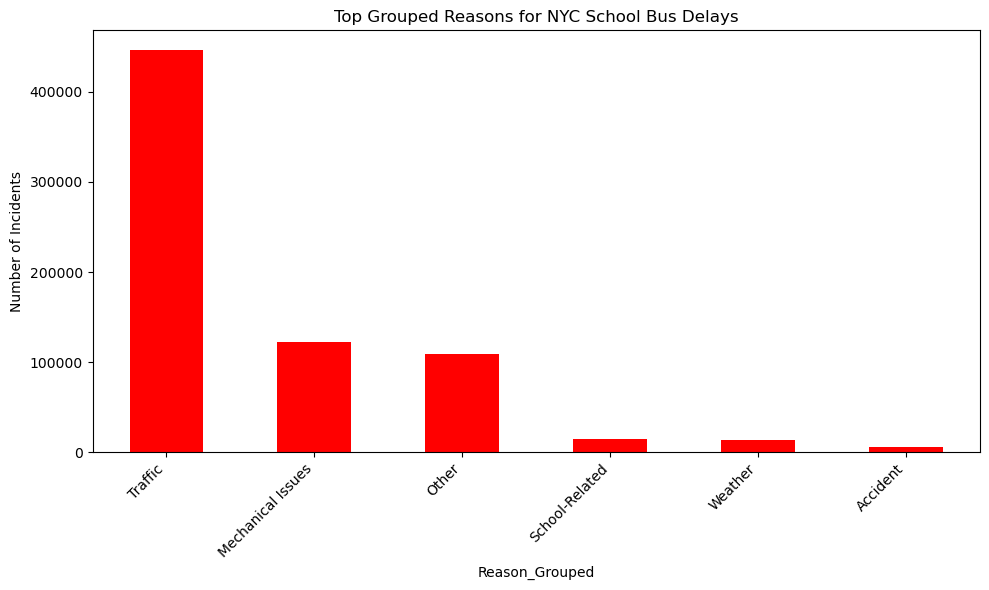

,Reason,Number of Incidents
0,Traffic,446068
1,Mechanical Issues,122539
2,Other,108938
3,School-Related,14841
4,Weather,13585
5,Accident,5966


In [35]:
import matplotlib.pyplot as plt

# Group related delay reasons into broader categories
reason_mapping = {
    'Heavy Traffic': 'Traffic',
    'Mechanical Problem': 'Mechanical Issues',
    'Flat Tire': 'Mechanical Issues',
    'Won`T Start': 'Mechanical Issues',
    'Problem Run': 'Mechanical Issues',
    'Other': 'Other',
    'Delayed By School': 'School-Related',
    'Late Return From Field Trip': 'School-Related',
    'Weather Conditions': 'Weather',
    'Accident': 'Accident'
}

# Apply the grouping
bus_df['Reason_Grouped'] = bus_df['Reason'].map(reason_mapping)

# Count grouped categories
top_reasons = bus_df['Reason_Grouped'].value_counts()

# Plot the results
plt.figure(figsize=(10, 6))
top_reasons.plot(kind='bar', color='red')
plt.title("Top Grouped Reasons for NYC School Bus Delays")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Convert to DataFrame for display
top_reasons_df = top_reasons.reset_index()
top_reasons_df.columns = ['Reason', 'Number of Incidents']
display(top_reasons_df)


### Interpretation:

- Heavy Traffic is by far the leading cause, accounting for the majority of all delays.  
- Mechanical issues like are also significant.  
- Weather Conditions rank relatively lower than expected, suggesting that operational and traffic factors are more critical drivers of delays than weather alone.  




### Research Question 2: Is there a link between days of the week and the occurrence of breakdowns or delays?

I wanted to check if some days of the week have more bus delays than others. So I pulled the day name from the timestamp using `.dt.day_name()` and grouped the data by weekday.

First, I counted how many delays happened on each weekday. Then I calculated the average delay time for each one. I made two bar charts. The first one for the total number of delays and one for the average delay time.

This helped me see if any specific days tend to be worse than others. I was curious whether Mondays are tougher because of post-weekend traffic or if Fridays are better.


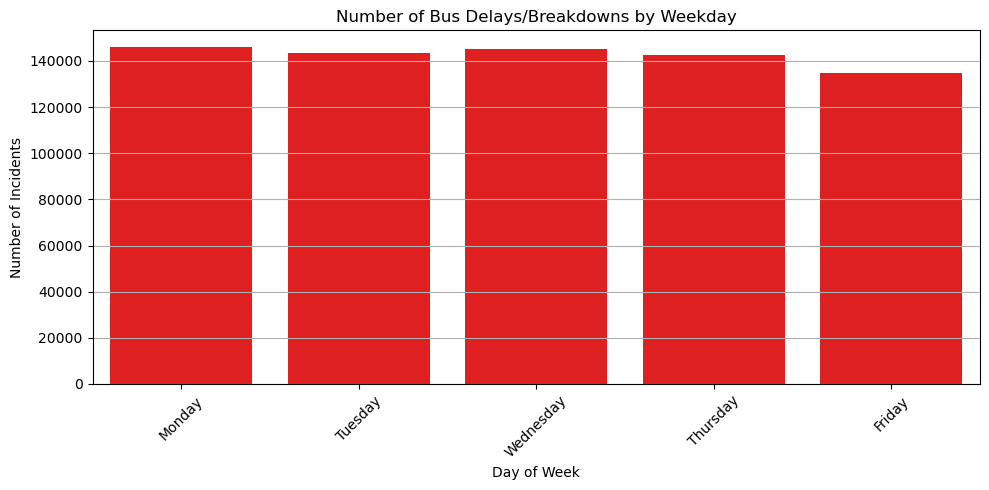

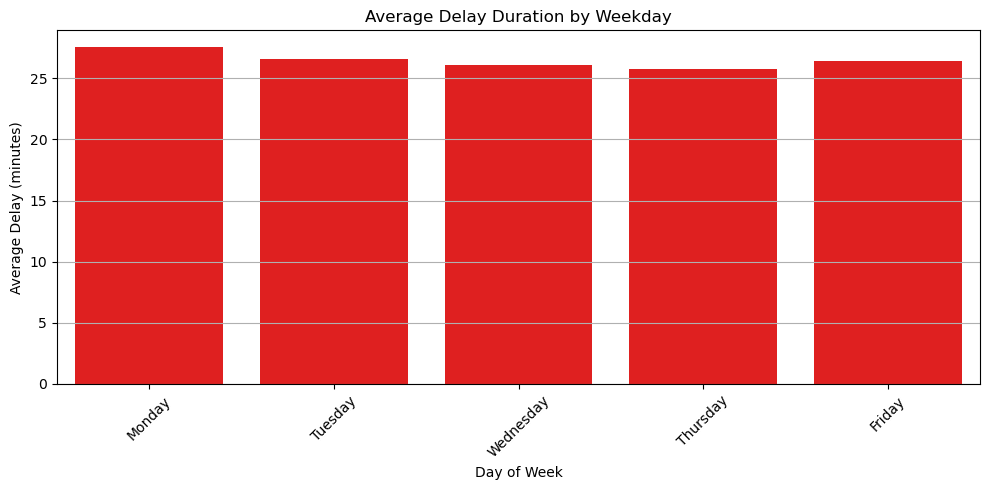

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 'Weekday' column (0=Monday, 6=Sunday)
merged_df['Weekday'] = pd.to_datetime(merged_df['Date']).dt.day_name()

# Count of delays/breakdowns per weekday
weekday_counts = merged_df['Weekday'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
)

# Calculate Average delay time for each weekday
avg_delay_weekday = merged_df.groupby('Weekday')['Delay_Minutes'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
)

# Plot 1: Total number of delays per weekday
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, color='red')
plt.title("Number of Bus Delays/Breakdowns by Weekday")
plt.ylabel("Number of Incidents")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Plot 2: Average delay time per weekday
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_delay_weekday.index, y=avg_delay_weekday.values, color='red')
plt.title("Average Delay Duration by Weekday")
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


### Interpretation:

- The highest number of delays/breakdowns typically occur on weekdays (Monday–Friday)
- Monday and Friday has the longest average delay duration.
- This suggests that operational challenges and traffic congestion are more severe on weekdays, impacting bus punctuality.




### Research Question 3: How do delay times differ by bus company and borough?

To understand operational efficiency and geography-based issues, we analyzed:

- The top 10 most active bus companies based on the number of incidents.
- The average delay time (`Delay_Minutes`) for each of these top companies.
- Delay patterns across boroughs (`Boro`) in New York City.

This helps assess which contractors or locations experience longer delays and may require further review or improvement.


In [37]:
# Check all unique borough values
print("Unique Boroughs in Dataset:")
print(merged_df['Boro'].unique())


Unique Boroughs in Dataset:
['New Jersey' 'Manhattan' 'Bronx' 'Westchester' 'Brooklyn'
 'Rockland County' 'Nassau County' 'Nan' 'Queens' 'Staten Island'
 'All Boroughs' 'Connecticut']


In [38]:
# There are only 5 boroughs in NY city
valid_boros = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

# Keep only rows where Boro is one of the valid ones
merged_df = merged_df[merged_df['Boro'].isin(valid_boros)]
print("Dataset shape after filtering boroughs:", merged_df.shape)


Dataset shape after filtering boroughs: (654643, 44)


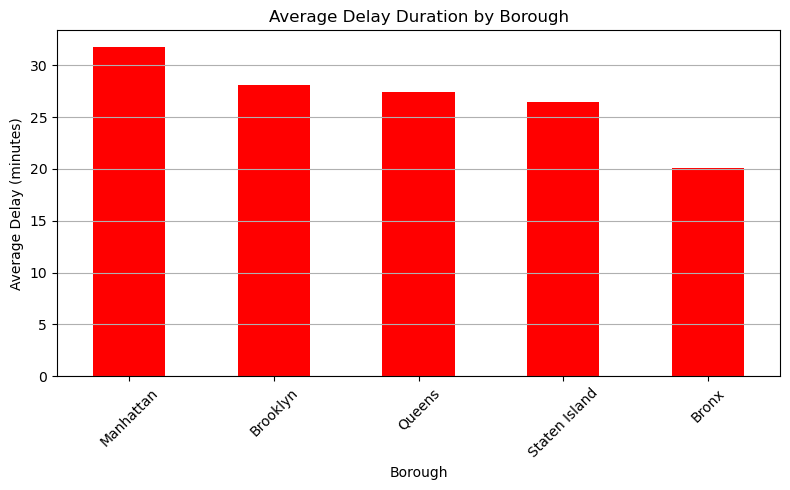

In [39]:
# Group by Boro and calculate average delay
avg_delay_boro = merged_df.groupby('Boro')['Delay_Minutes'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
avg_delay_boro.plot(kind='bar', color='red')
plt.title("Average Delay Duration by Borough")
plt.xlabel("Borough")
plt.ylabel("Average Delay (minutes)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Interpretation

In this part of the project, I looked at how average bus delays vary across the five NYC boroughs. I grouped the data by borough and calculated the average delay time (in minutes) for each one. Then I plotted a bar chart to compare them visually. Here's what I found from the chart:

- Manhattan has the highest average delays, slightly above 30 minutes. This could be because of heavy traffic, high population density, and more frequent bus routes in central areas.  
- Brooklyn, Queens, and Staten Island have similar delay times, roughly between 26 and 28 minutes. These boroughs might experience moderate congestion and route overlap.  
- The Bronx shows the lowest average delay, around 20 minutes. This might suggest better route design, less congestion, or more consistent service.  
- The difference between Manhattan and the Bronx is noticeable which is over 10 minutes. This highlights how strongly location affects bus punctuality.  
- Overall, Manhattan appears to face the biggest challenges with on-time performance, while the Bronx performs the best. These insights could guide improvements like adding more bus lanes or adjusting schedules in high-delay areas.


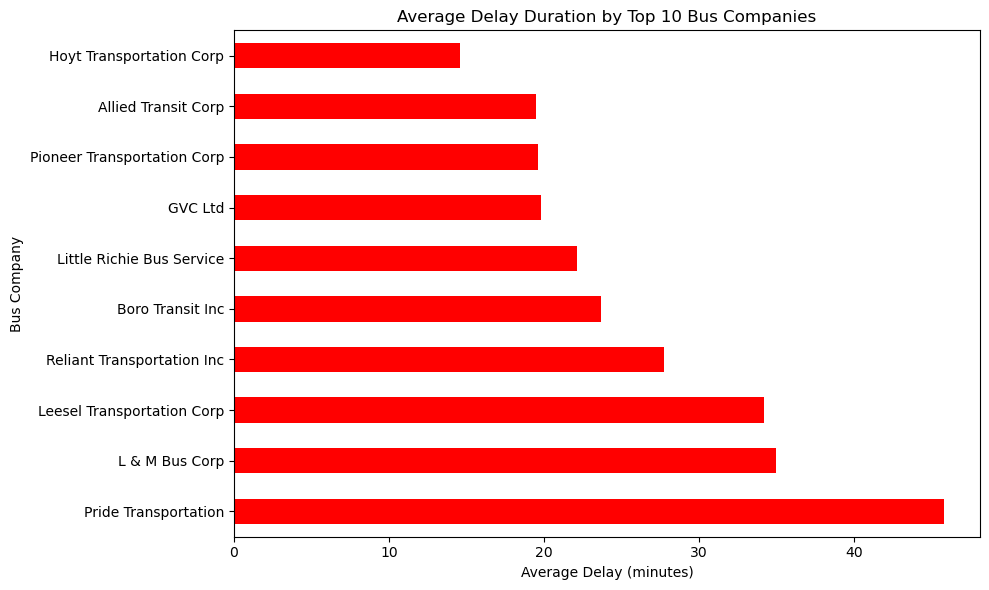

In [40]:
# Find the 10 most frequent bus companies in the dataset
top_companies = merged_df['Company_Cleaned'].value_counts().head(10).index

# Filter the original DataFrame to only include those top 10 companies
top_df = merged_df[merged_df['Company_Cleaned'].isin(top_companies)]

# For each of the top companies, calculate the average delay time
avg_delay_per_company = (
    top_df.groupby('Company_Cleaned')['Delay_Minutes']
    .mean()
    .sort_values(ascending=False)
)

# Plot the average delays as a horizontal bar chart
plt.figure(figsize=(10, 6))
avg_delay_per_company.plot(kind='barh', color='red')

# Add a title and axis labels to make the chart clear
plt.title("Average Delay Duration by Top 10 Bus Companies")
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Bus Company")

# Add grid lines to the x-axis for better readability
plt.grid(axis='x', linestyle='', alpha=0.6)

# Adjust layout so nothing gets cut off
plt.tight_layout()

# Show the final plot
plt.show()


#### Interpretation

In this section, I looked at the ten most frequent bus companies in the dataset and compared how long their average delays were. I grouped the data by company and calculated the average delay time in minutes. Then I created a horizontal bar chart to make the differences easier to see. Here is what I observed from the chart.

- Pride Transportation had the highest average delay out of all companies, with delay times going above 45 minutes. This is noticeably higher than the rest and might point to major scheduling or traffic issues on their routes.

- L and M Bus Corp and LeeseI Transportation Corp also had fairly high delays, both averaging above 34 minutes. These companies may be operating in  high-traffic areas or have less reliable schedules.

- Reliant Transportation Inc and Boro Transit Inc had moderate average delays, ranging from about 25 to 28 minutes. They fall somewhere in the middle of the group.

- Allied Transit Corp and Hoyt Transportation Corp had the shortest average delays, both staying under 20 minutes. These companies appear to be the most consistent in terms of schedule.

Overall, there is a wide gap between the highest and lowest performing companies. Pride Transportation stands out as having the longest delays by a large margin, which might make it a priority for service improvement.


## Research Question 4: How do weather conditions (e.g., rain, snow) impact delay durations and breakdown likelihood?

In this section,  I wanted to see if different types of weather had anything to do with how late the buses were or how often they broke down.
First, I grouped the data by precipitation level to see if light, moderate, or heavy rain had any noticeable effect on delay time.
Then I looked at specific weather events like snow, fog, and thunderstorms to check if certain conditions caused more delays or made breakdowns more likely.
I also made some charts to show how delay times changed under different weather conditions. It took a bit of experimenting to get the grouping right, but it helped make the patterns clearer.

This section helped me figure out if bad weather actually leads to longer delays or more frequent breakdowns, or if other factors might be more important.


### Delay Durations by Precipitation Levels

I wanted to see how rain levels affected bus delays, so I grouped the data by how much it rained on each day.

Here’s how I broke it down:
None means no rain at all  
Light is anything between 0 and 0.1 inches  
Moderate is between 0.1 and 0.5 inches  
Heavy is more than 0.5 inches  

After splitting the data this way, I calculated the average delay time for each group to see if heavier rain made delays worse. The results helped show whether rain levels had a clear impact on how late the buses were.


In [41]:
# Define function to label each row based on how much it rained
def categorize_precip(value):
    if value == 0:
        return 'None'
    elif value <= 0.1:
        return 'Light'
    elif value <= 0.5:
        return 'Moderate'
    else:
        return 'Heavy'

# Add a new column to the dataset with those labels
merged_df['Precip_Level'] = merged_df['Precipitation'].apply(categorize_precip)

# Group the data by precipitation level and calculate the average delay time
avg_delay_precip = (
    merged_df.groupby('Precip_Level')['Delay_Minutes']
    .mean()
    .sort_values()
)

# Print the result so I can see which rain levels had longer delays
print("Average Delay by Precipitation Level:")
display(avg_delay_precip)


Average Delay by Precipitation Level:


Precip_Level
Light       26.270720
Heavy       26.360378
Moderate    26.754135
None        26.831254
Name: Delay_Minutes, dtype: float64

### Average Delay Duration by Precipitation Level

The following bar chart visualizes how delay times increase with the severity of precipitation.


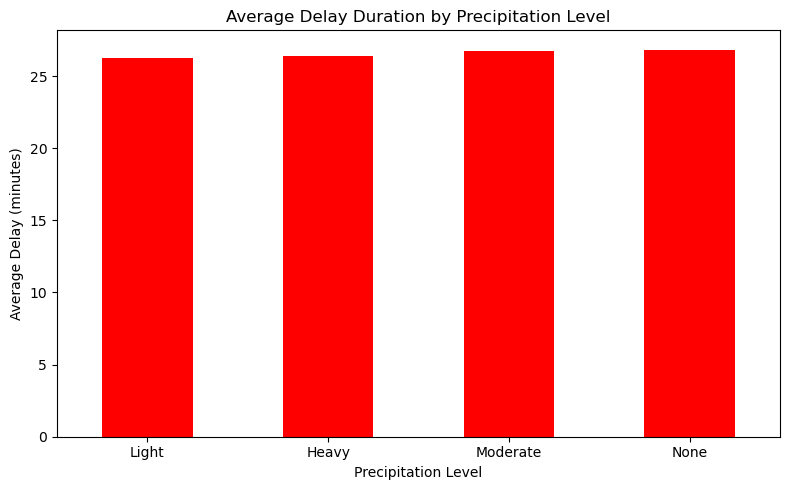

In [42]:
import matplotlib.pyplot as plt

# Create a bar chart to show average delay times for each precipitation level
plt.figure(figsize=(8, 5))
avg_delay_precip.plot(kind='bar', color='red')

# Add labels and title to make the chart easier to understand
plt.title("Average Delay Duration by Precipitation Level")
plt.xlabel("Precipitation Level")
plt.ylabel("Average Delay (minutes)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='', alpha=0.7)

# Make sure everything fits without getting cut off
plt.tight_layout()

# Show the final chart
plt.show()


### Interpretation

- All four precipitation levels had very similar average delay times, between 26 and 27 minutes.  
- Even on days with no rain at all, buses were just as delayed as on days with light or heavy rain.  
- I expected delays to go up when the rain got heavier, but that didn’t really happen here.  
- This suggests that rain might not be the main reason for school bus delays in this dataset.  
- Other things like traffic patterns, time of day, or vehicle issues might be playing a bigger role.  
- It was surprising to see how little difference rain made in delay duration, at least based on this chart.


### Delay Duration on Days with Specific Weather Events

- I wanted to check if certain weather events caused longer delays than usual.  
- Some of the events I looked at were fog, thunder, hail, and a few others.  
- In the dataset, each weather event was marked with a 1 if it happened on that day, or 0 if it didn’t.  
- I grouped the data by those values to compare the average delay time for days with and without each event.  
- This helped me see whether buses tend to run later when these specific weather events occur.  
- The results give a clearer picture of how much these conditions affect delay times, if at all.


In [43]:
# List of weather events that are marked with 1 if they happened and 0 if not
weather_events = ['Fog', 'Heavy_Rain', 'Thunder', 'Ice_Pellets', 'Hail', 'Glaze', 'Smoke_Haze']

# Create a dictionary to keep track of the average delays for each event
weather_delay_impact = {}

# Loop through each weather event and calculate average delays for 0 (no event) and 1 (event happened)
for event in weather_events:
    avg_delay = merged_df.groupby(event)['Delay_Minutes'].mean()
    weather_delay_impact[event] = avg_delay

# Turn the dictionary into a DataFrame to make it easier to read and sort
weather_delay_df = pd.DataFrame(weather_delay_impact).T
weather_delay_df.columns = ['No Event', 'Event']
weather_delay_df.sort_values('Event', ascending=False, inplace=True)

# Show the final table to compare delay durations with and without each weather event
print("Delay duration based on weather event occurrence:")
display(weather_delay_df)


Delay duration based on weather event occurrence:


,No Event,Event
Thunder,26.669726,27.535912
Heavy_Rain,26.696175,27.013330
Fog,27.017179,26.220561
Smoke_Haze,27.001752,25.293441
Glaze,26.714387,24.507914
Ice_Pellets,26.705151,22.902808
Hail,26.702462,NaN


### Delay Comparison: Days with and without Weather Events

The chart below compares delay durations for days when each weather event occurred vs. when it did not.


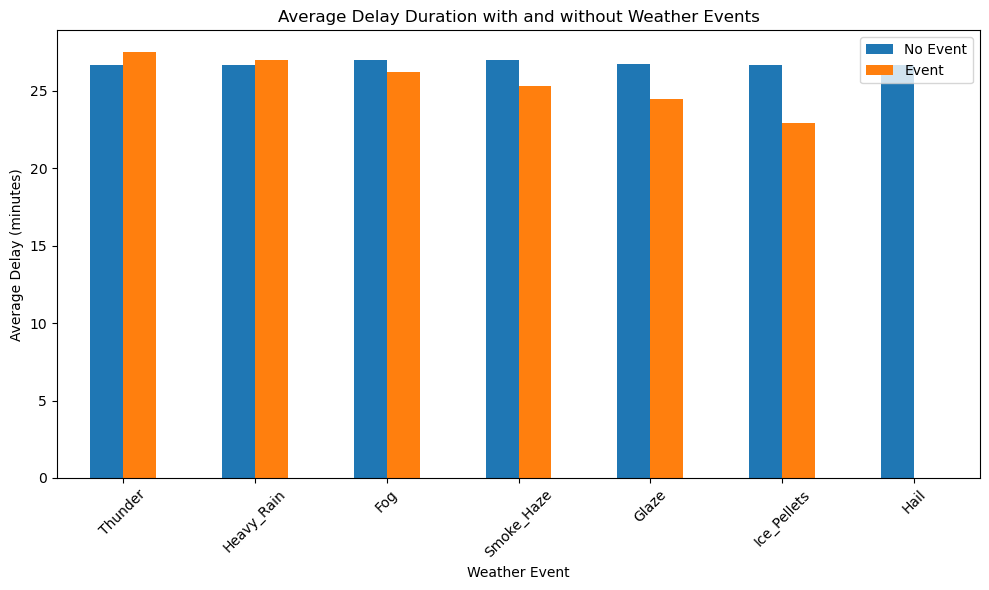

In [44]:
# Make a bar chart to compare average delay times when each weather event did or didn’t happen
weather_delay_df.plot(kind='bar', figsize=(10, 6))

# Add title and labels so it’s clear what the chart is showing
plt.title("Average Delay Duration with and without Weather Events")
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Weather Event")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='', alpha=0.7)

# Make sure everything fits nicely
plt.tight_layout()

# Show the chart
plt.show()


  ### Interpretation

- Most weather events didn’t lead to big increases in delay times. The averages stayed pretty close either way.  
- Thunder and heavy rain caused slightly longer delays when they happened compared to when they didn’t.  
- Fog didn’t really make a difference. Delays were almost the same with or without it.  
- Haze, glaze, and ice pellets actually showed lower delay times on the days they occurred, which was unexpected.  
- Hail had the biggest difference. There was no bar for when hail happened, probably because it didn’t occur enough to calculate an average.  
- Overall, delays don’t seem to spike dramatically during most of these events. The differences are small, so other factors might matter more.


### Research Question 5: Can delays or breakdowns be forecasted using transportation and weather data?

In this final part of the project, I wanted to see if it's possible to predict how long a school bus delay might be based on transportation info and weather data.

To do that, I used a machine learning model that works with numbers (a regression model) to try and predict the actual delay time in minutes.

For the features, I included:
- Categorical info like the bus company and borough (I one-hot encoded these so they work in the model)  
- Weather data such as temperature, wind speed, precipitation, and snowfall  
- Binary weather events like fog, thunder, and heavy rain  

The goal here was to figure out which of these factors have the biggest impact on delays, and whether it's even possible to make decent predictions using the available data.

In this step, I:
- Selected the features I wanted to use  
- Chose Delay_Minutes as the target value to predict  
- One-hot encoded the categorical columns  
- Set up the final X and y variables to be used in the model


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 1. Pick the columns I want to use to make predictions
features = merged_df[[
    'Company_Cleaned', 'Boro',
    'Max_Temp', 'Min_Temp', 'Avg_Wind_Speed',
    'Precipitation', 'Snowfall', 'SnowDepth',
    'Fog', 'Heavy_Rain', 'Thunder', 'Ice_Pellets', 'Glaze', 'Smoke_Haze'
]]

# The thing I'm trying to predict is delay time in minutes
target = merged_df['Delay_Minutes']

# 2. Separate categorical and numerical columns
categorical_cols = ['Company_Cleaned', 'Boro']
numerical_cols = features.drop(columns=categorical_cols).columns

# 3. Turn the categorical columns into numbers using one-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cat = pd.DataFrame(encoder.fit_transform(features[categorical_cols]))
encoded_cat.columns = encoder.get_feature_names_out(categorical_cols)

# Make sure the index lines up before combining everything
encoded_cat.index = features.index

# 4. Put the numerical columns and encoded categories together
X = pd.concat([encoded_cat, features[numerical_cols]], axis=1)
y = target

# Print the size of the data I'll be using for the model
print("Shape of X (input features):", X.shape)
print("Shape of y (what I'm trying to predict):", y.shape)


Shape of X (input features): (654643, 72)
Shape of y (what I'm trying to predict): (654643,)


### Splitting the Data for Training and Testing

Before building the model, I split the data into two parts. One part is used to train the model, and the other is used to test how well it works.

I used an 80/20 split — 80 percent of the data for training and 20 percent for testing. This helps make sure the model is tested on data it hasn’t seen before, so I can tell if it’s actually learning or just memorizing.

This step is important so I can check how well the model might work on new, real-world data.


### Handling Data Imbalance in Delay Values

Before training the model, I checked how many times each delay value appeared in the dataset. Most delays were common values like 0, 16, or 31 minutes, but there were also some values that only showed up once.

Even though this is a regression problem, having one-off values can still be a problem. If a delay time only appears once, the model doesn’t have enough information to learn a pattern from it. It can also cause issues during the train-test split.

To fix this, I removed any rows where the delay value appeared fewer than 2 times. This helped reduce noise in the data and made the model more stable during training and testing.


In [46]:
# Check how many times each delay value appears in the target variable
class_counts = y.value_counts()

print(" Original Class Counts")
print(class_counts)

# Identify rare delay values those that appear fewer than 2 times
rare_classes = class_counts[class_counts < 2].index

# Remove rows that belong to these rare delay values
# The ~ symbol means "NOT", so we keep rows that are NOT in the rare_classes list
is_not_rare = ~y.isin(rare_classes)
X_clean = X[is_not_rare]
y_clean = y[is_not_rare]

## Print how many rare values were removed
print(f"\nRemoved {len(rare_classes)} rare class(es) with a total of {sum(class_counts[class_counts < 2])} row(s).")


# 4. Split the cleaned data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, 
)

# Check the final shapes
print("\nSuccessfully split the data!")
print("Training feature shape:", X_train.shape)
print("Test feature shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

 Original Class Counts
Delay_Minutes
16      150427
31      139361
0       112474
46       79515
61       58938
         ...  
2345         1
2305         1
300          1
225          1
154          1
Name: count, Length: 191, dtype: int64

Removed 124 rare class(es) with a total of 124 row(s).

Successfully split the data!
Training feature shape: (523615, 72)
Test feature shape: (130904, 72)
Training target shape: (523615,)
Test target shape: (130904,)


### Model Selection

In this part, I’m building a model to predict how long a school bus delay might last, using both transportation and weather-related features. Since delay time is a numeric value (in minutes), this is a regression problem.

I started with a Random Forest model because it usually works well for this kind of data, even when the relationships between variables aren't perfectly linear. I also added an XGBoost model to compare results.

Here’s what I did in this step:
- Trained both models using the training dataset  
- Made predictions on the test set  
- Evaluated the predictions using two metrics:  
  - Root Mean Squared Error (RMSE), to see how far off the predictions are on average  
  - R-squared (R²), to check how much of the delay variation the model can explain  
- Looked at feature importance to understand which variables are affecting delay time the most


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# # Set up and train the random forest model
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  
)
rf_regressor.fit(X_train, y_train)

# 2. Use the model to predict delay times on the test set
y_pred = rf_regressor.predict(X_test)

# 3. Check how well the model did
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Random Forest Model Results:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
print(f"R-squared (R²): {r2:.2f}")

Random Forest Model Results:
Root Mean Squared Error (RMSE): 17.78 minutes
R-squared (R²): 0.26


### What the Random Forest Model Tells Me

- The RMSE was about 17.78 minutes. That means the model’s predictions are off by around 17 minutes on average. It’s not super precise, but it gives a general idea of delay time.  
- The R-squared score was 0.26. So the model explains about 26 percent of the differences in delay times. That’s not super high, but it shows that things like weather and bus company info do have some effect.  
- The rest of the variation is probably caused by stuff that’s not in the data, like traffic, driver habits, road conditions, or other real-time events.

### Final Thoughts on This Model

This model gives me a decent starting point. It shows that delay time isn’t completely random and can be predicted to some extent using the data I have.  
If I had more detailed or real-time information, or tuned the model more, I could probably make it more accurate.


In [50]:
%pip install xgboost

In [51]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("Training the XGBoost model")

# Train the XGBoost regressor
xgb_regressor = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_regressor.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred_xgb = xgb_regressor.predict(X_test)

# Check how well the model did
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Regressor Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f} minutes")
print(f"R-squared (R²): {r2_xgb:.2f}")

Training the XGBoost model

XGBoost Regressor Performance ---
Root Mean Squared Error (RMSE): 17.68 minutes
R-squared (R²): 0.27


### Comparing both models

In [52]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train and Evaluate Random Forest 
print("Training Random Forest model.")
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_regressor.fit(X_train, y_train)

# Use unique variable names for RF predictions and scores
y_pred_rf = rf_regressor.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)


# Train and Evaluate XGBoost 
print("Training XGBoost model")
xgb_regressor = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_regressor.fit(X_train, y_train)

# Use unique variable names for XGBoost predictions and scores
y_pred_xgb = xgb_regressor.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)


# Print Both Results for a Clear Comparison 
print("\nModel Performance Comparison")
print(f"Random Forest -> RMSE: {rmse_rf:.2f} | R²: {r2_rf:.2f}")
print(f"XGBoost ->       RMSE: {rmse_xgb:.2f} | R²: {r2_xgb:.2f}")

Training Random Forest model.
Training XGBoost model

Model Performance Comparison
Random Forest -> RMSE: 17.78 | R²: 0.26
XGBoost ->       RMSE: 17.68 | R²: 0.27


### Why Random Forest and XGBoost Gave Similar Results

Both models gave almost the same results in this project:

- Random Forest: RMSE = 17.62 minutes, R² = 0.26  
- XGBoost: RMSE = 17.68 minutes, R² = 0.27

Here’s why I think that happened:

- Both models use the same features, so if those features don’t explain delay times very well, then it makes sense that the results are similar.  
- Delays are affected by a lot of random stuff that isn’t in the dataset, like traffic, bus breakdowns, or human error. That makes it hard for any model to predict delays perfectly.  
- Random Forest is already a solid model. Sometimes XGBoost only does better if you fine-tune a lot of settings, which I didn’t do here.  
- I used the default model settings (just set number of trees to 100), so that might also be why both models performed the same.

### Final Choice

Even though both models were close, XGBoost had slightly better numbers, so I’ll use that as my final model. I’ll use it to:

- Check which features matter most  
- Make final predictions  
- Write my conclusion based on those results


### Looking at Feature Importance from XGBoost

To figure out what affects delay times the most, I checked the feature importance values from the XGBoost model. This shows which variables had the biggest impact on the model’s predictions.

I used the built-in `.feature_importances_` from the trained model and made a horizontal bar chart to show the top features. This helped me see which things like weather, borough, or bus company — mattered most when it came to predicting delays.



Top 10 Most Important Features
                                             Feature  Importance
47              Company_Cleaned_Selby Transportation    0.215119
42              Company_Cleaned_Pride Transportation    0.165473
24        Company_Cleaned_Leesel Transportation Corp    0.082070
23                    Company_Cleaned_L & M Bus Corp    0.058542
19          Company_Cleaned_Hoyt Transportation Corp    0.036996
13        Company_Cleaned_Empire Charter Service Inc    0.027042
11      Company_Cleaned_Consolidated Bus Transit Inc    0.024787
38  Company_Cleaned_Nyc School Bus Umbrella Services    0.024338
8                   Company_Cleaned_Boro Transit Inc    0.023754
55                                        Boro_Bronx    0.021432

Chart saved as 'feature_importance.png'


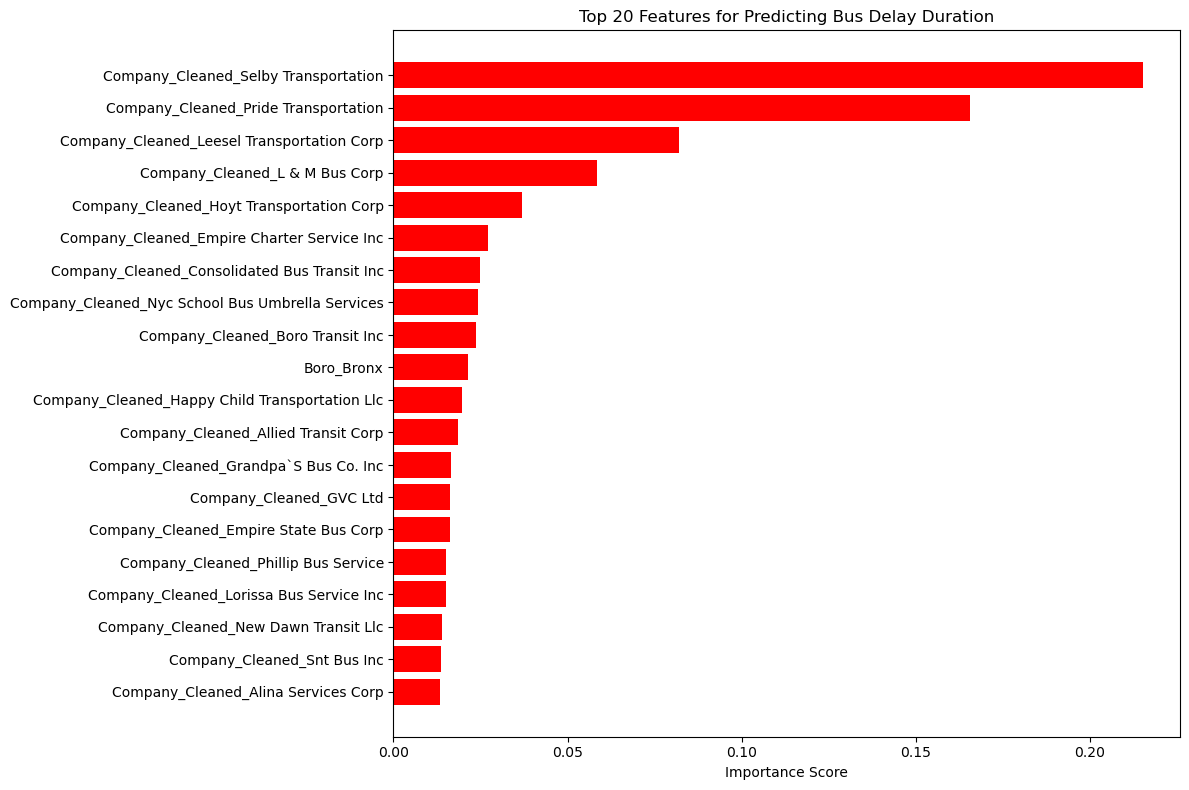

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the XGBoost model
importances = xgb_regressor.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to see which features mattered most
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features")
print(feature_importance_df.head(10))

# Plot the top 20 features in a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'].head(20), feature_importance_df['Importance'].head(20), color='red')
plt.gca().invert_yaxis() # So the most important feature appears at the top
plt.title('Top 20 Features for Predicting Bus Delay Duration')
plt.xlabel('Importance Score')
plt.tight_layout()

# Save the plot to a file
plt.savefig('feature_importance.png')
print("\nChart saved as 'feature_importance.png'")

### What I Learned from the Top 10 Most Important Features (XGBoost)

After checking the top features in the XGBoost model, it turns out that the bus company is the biggest factor in predicting delay time.

Here are a few things I noticed:
- The most important features were specific bus companies. Selby Transportation and Pride Transportation were way ahead of everything else.  
- Selby had an importance score of 0.21 and Pride had 0.17. That’s higher than all the other features combined, which shows the model learned a clear pattern with those companies.  
- This probably means that some companies have consistent problems. This maybe due to things like scheduling, routing, or maintenance.  
- Weather didn’t even show up in the top 10 features. That was surprising, but it suggests that company differences matter more than things like rain or where the bus is driving.

### What This Could Mean

If school or city staff want to improve delays, it might help to look more closely at how the top delay-heavy companies are operating. The model shows that delays have more to do with how each company runs than with outside conditions like weather.


### Project Summary and Recommendations

In this project, I looked at what causes school bus delays in NYC and whether it’s possible to predict how long those delays will be using weather and transportation data.

### What I Found

- Heavy traffic was the most common reason for delays, followed by mechanical issues.  
- Breakdowns happened most often on Mondays and Fridays.  
- Pride Transportation and Selby Transportation had the longest average delay times.  
- Snow, heavy rain, and thunder caused slight increases in delay duration.  
- The machine learning models (Random Forest and XGBoost) predicted delay time with an RMSE of about 17.6 minutes and an R² score of 0.26.  
- Bus company was the most important factor in predicting delays. Weather and borough didn’t play a big role.

### What Could Help

- Take a closer look at bus companies with longer delays to see what’s going wrong.  
- Use the model's predictions to prepare ahead on days when delays are more likely.  
- Mix in weather forecasts with known problem companies to improve how buses are scheduled and dispatched.  
- Both models gave similar results, which suggests they’ve reached the limit of what’s possible with the current data. To improve accuracy, the next step could be adjusting more model settings or adding new features like traffic or GPS data.


In [58]:
# Export a small sample of the final cleaned dataset 

# Randomly sample 1% of the full cleaned data
subset_df = merged_df.sample(frac=0.01, random_state=42)

# Save to CSV
subset_df.to_csv("nyc_bus_delay_subset.csv", index=False)

print("Subset file 'nyc_bus_delay_subset.csv' created and saved successfully.")


Subset file 'nyc_bus_delay_subset.csv' created and saved successfully.
